In [14]:
import pandas as pd
from google.colab import drive

drive.mount('/content/drive')

file_path = '/content/drive/My Drive/AGI/AGI project 2/diverse_eukaryotic_enzymes.csv'

# Load your dataset
original_df = pd.read_csv(file_path)
original_df

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,accession,Entry Name,organism,ec_number,length,protein_name,taxonomic_group,length_bin
0,P86215,PRDX6_MESAU,Mesocricetus auratus (Golden hamster),1.11.1.27; 2.3.1.23; 3.1.1.4,50,Peroxiredoxin-6 (EC 1.11.1.27) (1-Cys peroxire...,Mammals,NaN
1,Q9N117,RELN_BOVIN,Bos taurus (Bovine),3.4.21.-,52,Reelin (EC 3.4.21.-),Mammals,"(50, 60]"
2,P09873,CHYM_FELCA,Felis catus (Cat) (Felis silvestris catus),3.4.23.4,54,Chymosin (EC 3.4.23.4),Mammals,"(50, 60]"
3,P10626,ACRO_CAPHI,Capra hircus (Goat),3.4.21.10,60,Acrosin (EC 3.4.21.10) [Cleaved into: Acrosin ...,Mammals,"(50, 60]"
4,P13636,PEPA_URSTH,Ursus thibetanus (Asiatic black bear) (Selenar...,3.4.23.1,60,Pepsin A (EC 3.4.23.1),Mammals,"(50, 60]"
...,...,...,...,...,...,...,...,...
18071,O01391,UCHL_APLCA,Aplysia californica (California sea hare),3.4.19.12,214,Ubiquitin carboxyl-terminal hydrolase (EC 3.4....,Molluscs,"(210, 220]"
18072,P21901,KAPL_APLCA,Aplysia californica (California sea hare),2.7.11.1,351,Spermatozoon-associated protein kinase (SAK) (...,Molluscs,"(350, 360]"
18073,P21901,KAPL_APLCA,Aplysia californica (California sea hare),2.7.11.1,351,Spermatozoon-associated protein kinase (SAK) (...,Molluscs,"(350, 360]"
18074,P81124,GSTO_APLCA,Aplysia californica (California sea hare),1.20.4.2; 1.8.5.1; 2.5.1.18,92,Probable glutathione transferase (EC 2.5.1.18)...,Molluscs,"(90, 100]"


In [15]:
# Load sequences file downloaded from UniProt to check column names
sequences_df = pd.read_csv('/content/drive/My Drive/AGI/AGI project 2/CHL Final Run/uniprot_sequences.tsv', sep='\t')
print("Column names in the UniProt file:")
print(sequences_df.columns.tolist())

Column names in the UniProt file:
['From', 'Entry', 'Entry Name', 'Protein names', 'Gene Names', 'Organism', 'Length', 'Sequence']


In [16]:
# Merge the datasets on accession number
merged_df = pd.merge(original_df, sequences_df,
                     left_on='accession',
                     right_on='Entry',
                     how='left')

# Check how many sequences were retrieved
print(f"Original dataset: {len(original_df)} entries")
print(f"Entries with sequences: {merged_df['Sequence'].notna().sum()}")

# Save the merged dataset
merged_df.to_csv('eukaryotic_enzymes_with_sequences.csv', index=False)

Original dataset: 18076 entries
Entries with sequences: 18076


In [19]:
df = merged_df

## Protien Name (Rules 1 and 2)

In [20]:
import pandas as pd

# Load and clean data
df['length'] = pd.to_numeric(df['length'], errors='coerce')
df = df.dropna(subset=['length'])

# ---- Rule 1: Filter by protein_name ----
rule1_protein = []

for name, group in df.groupby('protein_name'):
    group = group.sort_values('length', ascending=False).reset_index(drop=True)
    to_keep = []

    for i in range(len(group)):
        keep = True
        for j in range(i):
            len_i = group.loc[i, 'length']
            len_j = group.loc[j, 'length']
            pct_diff = abs(len_j - len_i) / len_j

            if pct_diff < 0.2:
                keep = False
                break
        if keep:
            to_keep.append(group.loc[i])

    rule1_protein.extend(to_keep)

df_rule1_protein = pd.DataFrame(rule1_protein)
df_rule1_protein.to_csv('filtered_proteinname_rule1.csv', index=False)
print(f"Protein Name Rule 1: {len(df_rule1_protein)} sequences retained")

# ---- Rule 2: Filter by protein_name ----
rule2_protein = []

for name, group in df.groupby('protein_name'):
    group = group.sort_values('length').reset_index(drop=True)

    if len(group) == 1:
        rule2_protein.append(group.iloc[0])
    else:
        shortest = group.iloc[0]
        second_shortest = group.iloc[1]
        pct_diff = abs(shortest['length'] - second_shortest['length']) / second_shortest['length']

        if pct_diff < 0.2:
            rule2_protein.extend(group.iloc[1:].to_dict(orient='records'))
        else:
            rule2_protein.extend(group.to_dict(orient='records'))

df_rule2_protein = pd.DataFrame(rule2_protein)
df_rule2_protein.to_csv('filtered_proteinname_rule2.csv', index=False)
print(f"Protein Name Rule 2: {len(df_rule2_protein)} sequences retained")

Protein Name Rule 1: 2237 sequences retained
Protein Name Rule 2: 16197 sequences retained


## Sequence (Rules 1 and 2)

In [21]:
import pandas as pd

# Load dataset
df['length'] = pd.to_numeric(df['length'], errors='coerce')
df = df.dropna(subset=['length'])

# ===============================
# RULE 1 on Sequence
# ===============================
rule1_sequence = []

for _, group in df.groupby("Sequence"):
    group = group.sort_values("length", ascending=False).reset_index(drop=True)
    to_keep = []

    for i in range(len(group)):
        keep = True
        for j in range(i):
            len_i = group.loc[i, "length"]
            len_j = group.loc[j, "length"]
            diff = abs(len_j - len_i) / len_j

            if diff < 0.20:
                keep = False
                break
        if keep:
            to_keep.append(group.loc[i])

    rule1_sequence.extend(to_keep)

df_rule1_sequence = pd.DataFrame(rule1_sequence)
df_rule1_sequence.to_csv("filtered_sequence_rule1.csv", index=False)
print(f"✅ Sequence Rule 1: {len(df_rule1_sequence)} sequences retained")

# ===============================
# RULE 2 on Sequence
# ===============================
rule2_sequence = []

for _, group in df.groupby("Sequence"):
    group = group.sort_values("length").reset_index(drop=True)

    if len(group) == 1:
        rule2_sequence.extend(group.to_dict(orient="records"))
    else:
        len1 = group.iloc[0]["length"]
        len2 = group.iloc[1]["length"]
        diff = abs(len2 - len1) / max(len1, len2)

        if diff < 0.20:
            rule2_sequence.extend(group.iloc[1:].to_dict(orient="records"))  # remove shortest
        else:
            rule2_sequence.extend(group.to_dict(orient="records"))  # keep all

df_rule2_sequence = pd.DataFrame(rule2_sequence)
df_rule2_sequence.to_csv("filtered_sequence_rule2.csv", index=False)
print(f"✅ Sequence Rule 2: {len(df_rule2_sequence)} sequences retained")


✅ Sequence Rule 1: 3440 sequences retained
✅ Sequence Rule 2: 15103 sequences retained


In [22]:
import pandas as pd
import matplotlib.pyplot as plt

# Load all filtered datasets
df_original = df
df_prot_r1 = df_rule1_protein
df_prot_r2 = df_rule2_protein
df_seq_r1 = df_rule1_sequence
df_seq_r2 = df_rule2_sequence

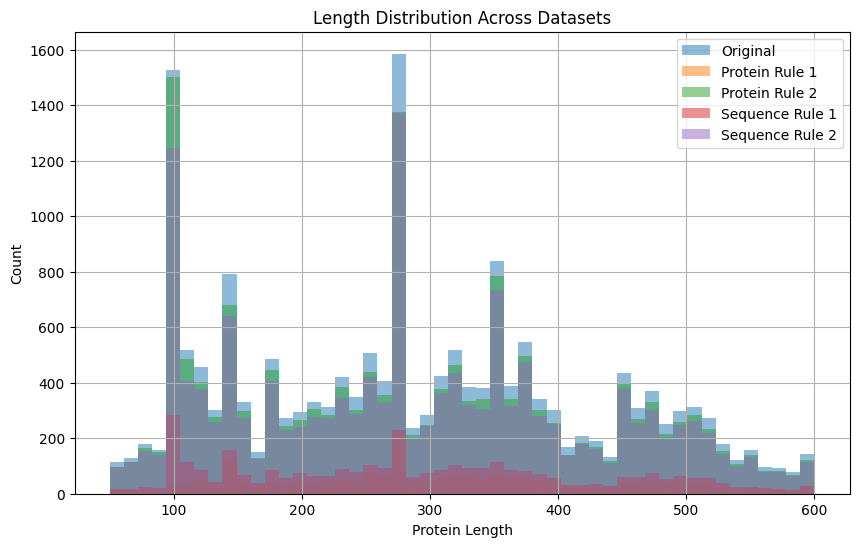

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [42]:
plt.figure(figsize=(10, 6))

plt.hist(df_original['length'], bins=50, alpha=0.5, label='Original')
plt.hist(df_prot_r1['length'], bins=50, alpha=0.5, label='Protein Rule 1')
plt.hist(df_prot_r2['length'], bins=50, alpha=0.5, label='Protein Rule 2')
plt.hist(df_seq_r1['length'], bins=50, alpha=0.5, label='Sequence Rule 1')
plt.hist(df_seq_r2['length'], bins=50, alpha=0.5, label='Sequence Rule 2')

plt.title("Length Distribution Across Datasets")
plt.xlabel("Protein Length")
plt.ylabel("Count")
plt.legend()
plt.grid(True)
plt.savefig('length_distribution.png')  # You can change the filename and format here
plt.show()

from google.colab import files
files.download('length_distribution.png')

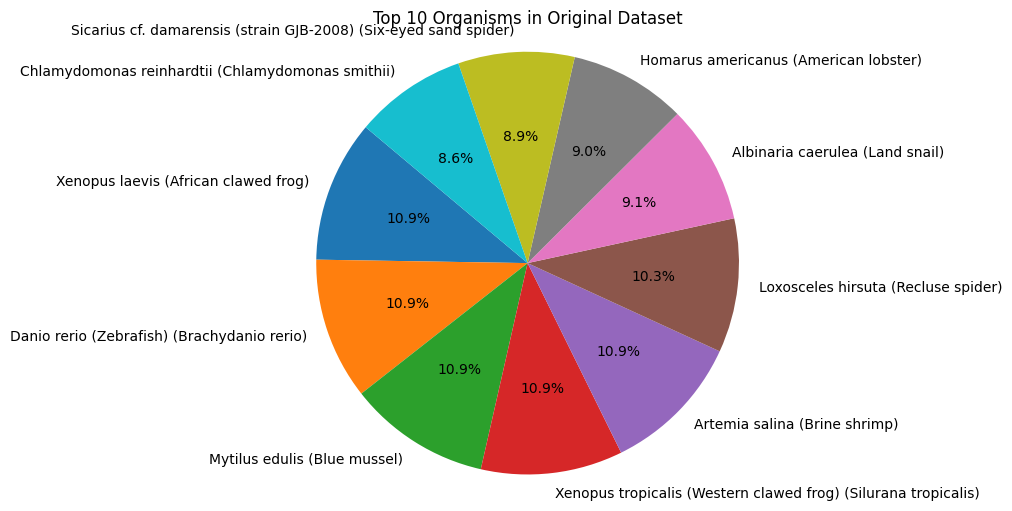

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [43]:
top_orgs = df_original['Organism'].value_counts().nlargest(10)
plt.figure(figsize=(6, 6))
plt.pie(top_orgs, labels=top_orgs.index, autopct='%1.1f%%', startangle=140)
plt.title("Top 10 Organisms in Original Dataset")
plt.axis('equal')
plt.savefig('Top 10 Organisms in Original Dataset.png')  # You can change the filename and format here
plt.show()

from google.colab import files
files.download('Top 10 Organisms in Original Dataset.png')

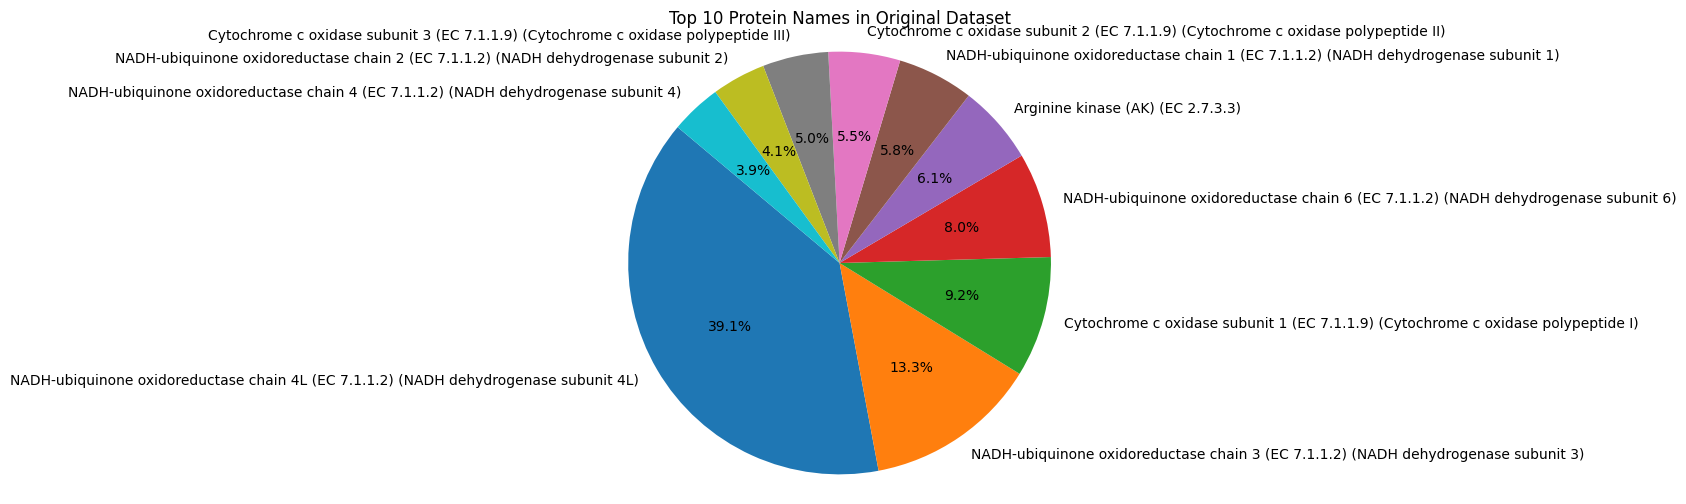

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [44]:
top_prots = df_original['protein_name'].value_counts().nlargest(10)
plt.figure(figsize=(6, 6))
plt.pie(top_prots, labels=top_prots.index, autopct='%1.1f%%', startangle=140)
plt.title("Top 10 Protein Names in Original Dataset")
plt.axis('equal')
plt.savefig('Top 10 Protein Names in Original Dataset.png')  # You can change the filename and format here
plt.show()

from google.colab import files
files.download('Top 10 Protein Names in Original Dataset.png')

In [26]:
import numpy as np
from scipy.signal import periodogram
import matplotlib.pyplot as plt

# Clean up and get the length frequency
df['length'] = pd.to_numeric(df['length'], errors='coerce')
df = df.dropna(subset=['length'])
length_counts = df['length'].value_counts().sort_index()

# Create the frequency vector
max_length = length_counts.index.max()
freq_vector = np.zeros(max_length + 1)
for length, count in length_counts.items():
    freq_vector[int(length)] = count

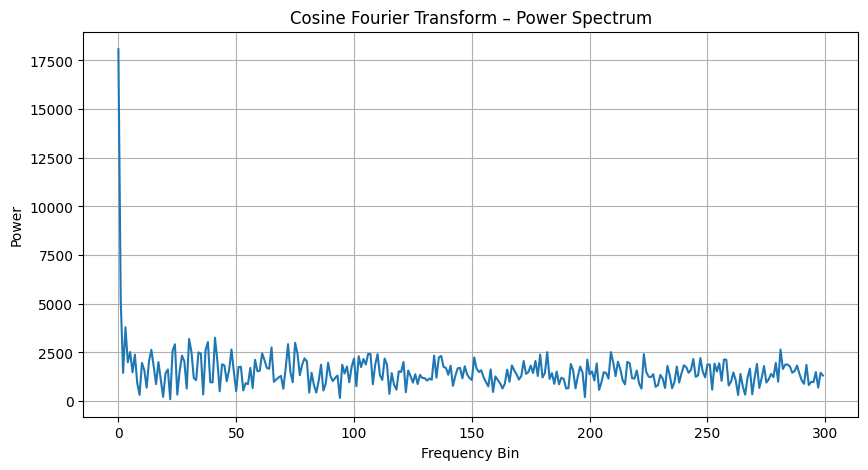

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [45]:
# Apply FFT (use only positive frequencies)
fft_result = np.fft.fft(freq_vector)
power_spectrum = np.abs(fft_result[:len(fft_result)//2])  # One-sided spectrum

plt.figure(figsize=(10, 5))
plt.plot(power_spectrum)
plt.title("Cosine Fourier Transform – Power Spectrum")
plt.xlabel("Frequency Bin")
plt.ylabel("Power")
plt.grid(True)
plt.savefig('Cosine Fourier Transform – Power Spectrum.png')  # You can change the filename and format here
plt.show()

from google.colab import files
files.download('Cosine Fourier Transform – Power Spectrum.png')

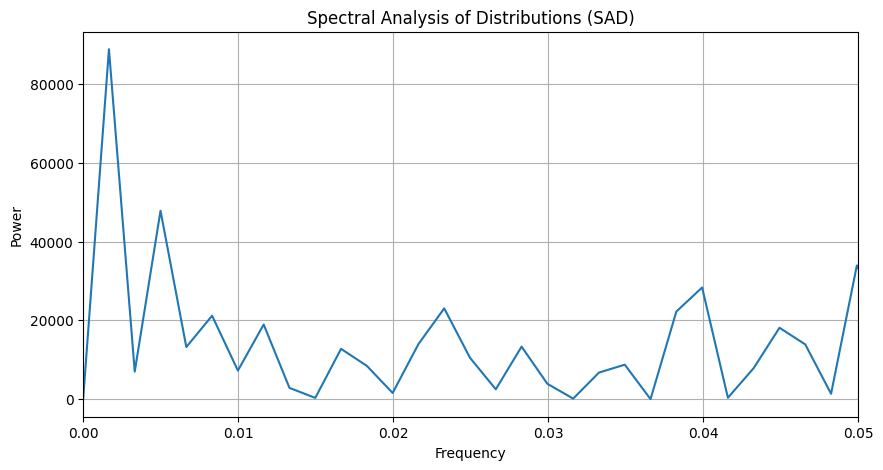

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [46]:
frequencies, power = periodogram(freq_vector)

plt.figure(figsize=(10, 5))
plt.plot(frequencies, power)
plt.title("Spectral Analysis of Distributions (SAD)")
plt.xlabel("Frequency")
plt.ylabel("Power")
plt.xlim(0, 0.05)  # Zoom in to the relevant frequency range
plt.grid(True)
plt.savefig('Spectral Analysis of Distributions (SAD).png')  # You can change the filename and format here
plt.show()

from google.colab import files
files.download('Spectral Analysis of Distributions (SAD).png')

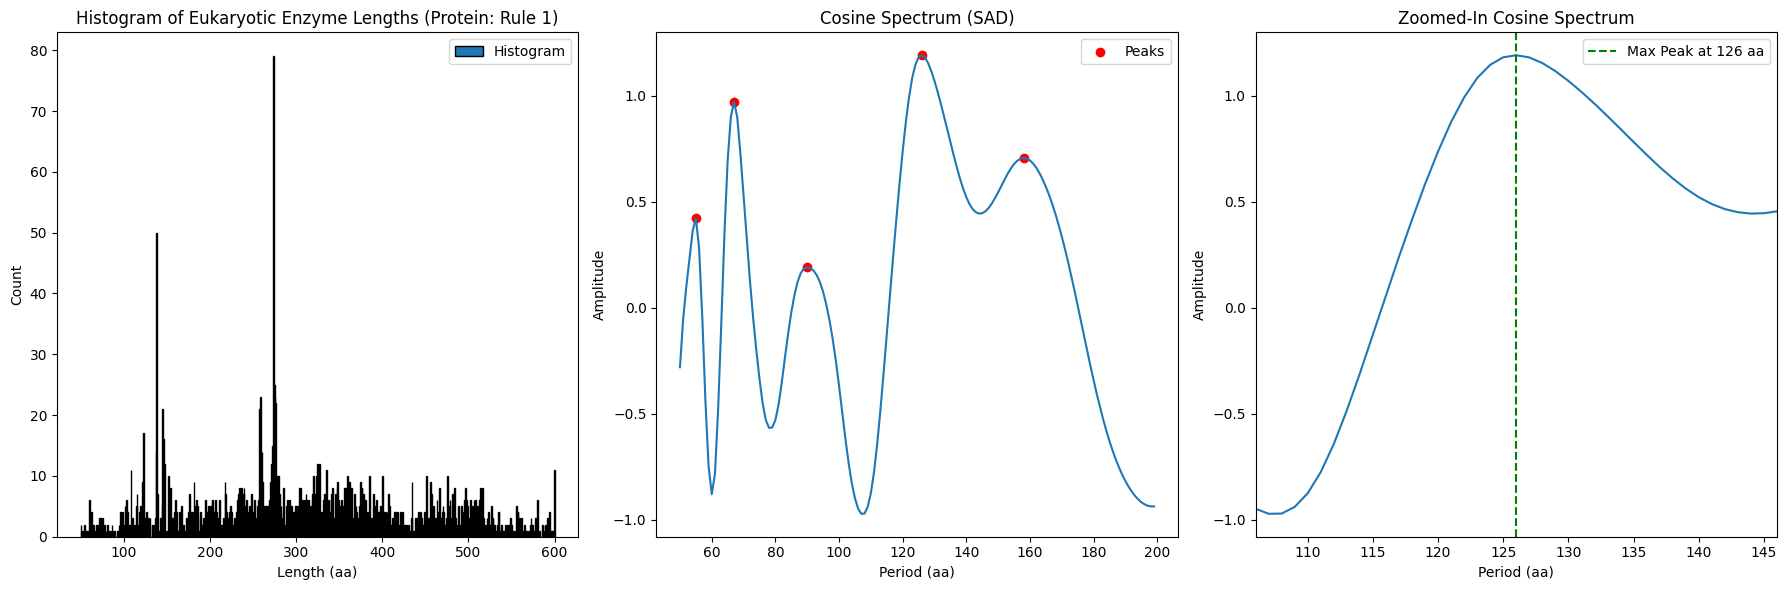

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Detected Peaks:
Period: 55 aa, Amplitude: 0.42149
Period: 67 aa, Amplitude: 0.97053
Period: 90 aa, Amplitude: 0.19067
Period: 126 aa, Amplitude: 1.19029
Period: 158 aa, Amplitude: 0.70594

Maximum Peak Period: 126 aa with Amplitude: 1.19029


In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Load Rule 1 filtered data
filtered_df_rule1 = df_prot_r1

# Step 1: Extract the 'length' column
enzyme_lengths = filtered_df_rule1['length']

# Step 2: Create a histogram (raw counts)
bin_width = 1
bins = np.arange(50, 601, bin_width)
hist, bin_edges = np.histogram(enzyme_lengths, bins=bins)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Step 3–4: Generate cosine spectrum using SAD approach
periods = np.arange(50, 200, 1)
cosine_spectrum = []

for period in periods:
    window = period
    hist_series = pd.Series(hist)
    background = hist_series.rolling(window=window, center=True, min_periods=1).mean().to_numpy()
    osc = hist - background
    valid = ~np.isnan(background)

    cosine_wave = np.cos(2 * np.pi * bin_centers / period)
    numerator = np.sum(osc[valid] * cosine_wave[valid])
    denominator = np.sum(cosine_wave[valid] ** 2)
    amplitude = numerator / denominator
    cosine_spectrum.append(amplitude)

cosine_spectrum = np.array(cosine_spectrum)

# Step 5: Find peaks
peaks, _ = find_peaks(cosine_spectrum)

# Step 6: Plot
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].bar(bin_centers, hist, width=bin_width, edgecolor="black", label="Histogram")
axes[0].set_title("Histogram of Eukaryotic Enzyme Lengths (Protein: Rule 1)")
axes[0].set_xlabel("Length (aa)")
axes[0].set_ylabel("Count")
axes[0].legend()

axes[1].plot(periods, cosine_spectrum)
axes[1].scatter(periods[peaks], cosine_spectrum[peaks], color='red', label="Peaks")
axes[1].set_title("Cosine Spectrum (SAD)")
axes[1].set_xlabel("Period (aa)")
axes[1].set_ylabel("Amplitude")
axes[1].legend()

peak_periods = periods[peaks]
peak_amplitudes = cosine_spectrum[peaks]
max_peak_idx = np.argmax(peak_amplitudes)
max_period = peak_periods[max_peak_idx]

axes[2].plot(periods, cosine_spectrum)
axes[2].axvline(max_period, color='green', linestyle='--', label=f"Max Peak at {max_period} aa")
axes[2].set_xlim(max_period - 20, max_period + 20)
axes[2].set_title("Zoomed-In Cosine Spectrum")
axes[2].set_xlabel("Period (aa)")
axes[2].set_ylabel("Amplitude")
axes[2].legend()

plt.tight_layout()
plt.savefig("SAD_Protein_Rule1.png", dpi=300, bbox_inches='tight')
plt.show()

from google.colab import files
files.download('SAD_Protein_Rule1.png')

# Print detected peaks
print("Detected Peaks:")
for i in range(len(peaks)):
    print(f"Period: {periods[peaks[i]]} aa, Amplitude: {cosine_spectrum[peaks[i]]:.5f}")

print(f"\nMaximum Peak Period: {max_period} aa with Amplitude: {peak_amplitudes[max_peak_idx]:.5f}")

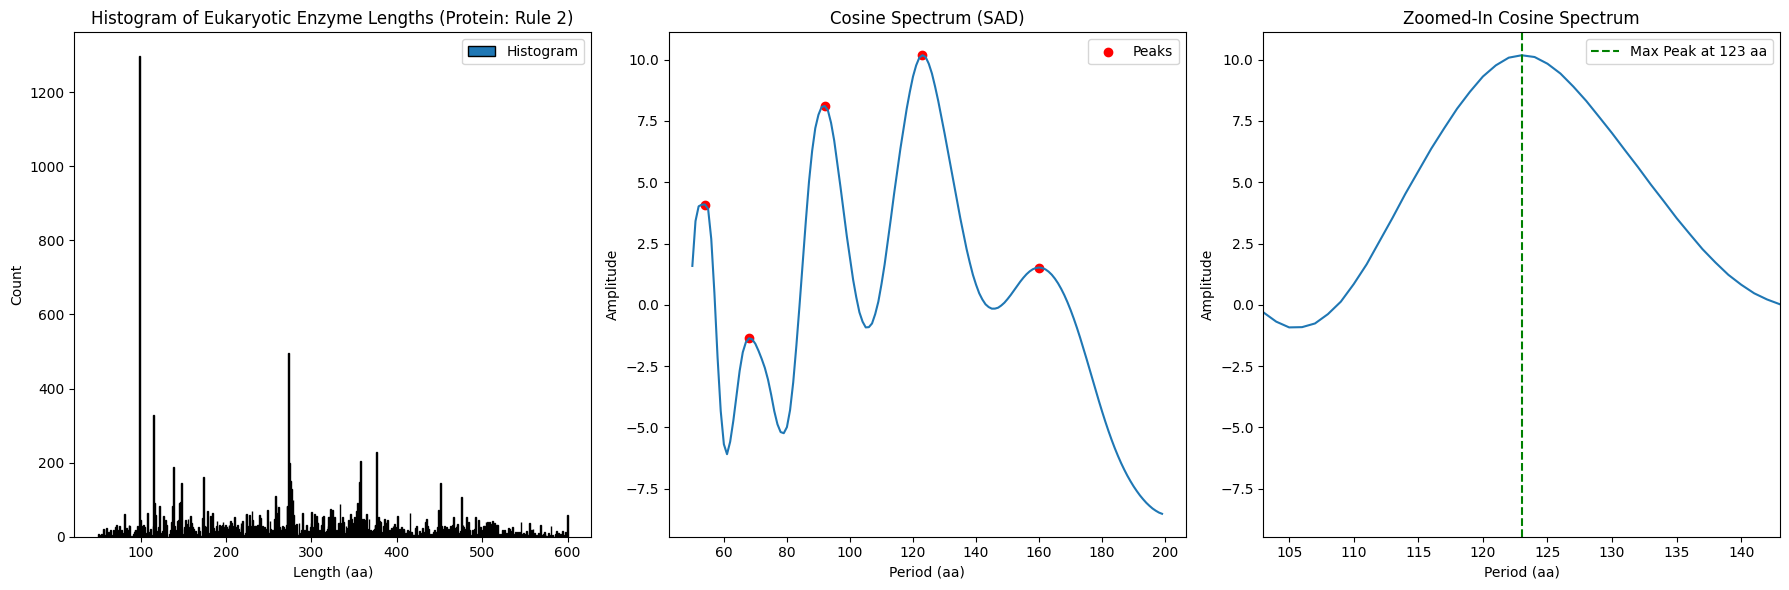

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Detected Peaks:
Period: 54 aa, Amplitude: 4.09276
Period: 68 aa, Amplitude: -1.36395
Period: 92 aa, Amplitude: 8.10836
Period: 123 aa, Amplitude: 10.17949
Period: 160 aa, Amplitude: 1.52193

Maximum Peak Period: 123 aa with Amplitude: 10.17949


In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Load Rule 2 filtered data
filtered_df_rule2 = df_prot_r2

# Step 1: Extract the 'length' column
enzyme_lengths = filtered_df_rule2['length']

# Step 2: Create a histogram (raw counts)
bin_width = 1  # smallest resolution to capture fine oscillations
bins = np.arange(50, 601, bin_width)  # Range: 50–600 aa
hist, bin_edges = np.histogram(enzyme_lengths, bins=bins)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Step 3–4: Generate cosine spectrum using SAD approach
periods = np.arange(50, 200, 1)  # Test periods from 50 to 199 aa
cosine_spectrum = []

for period in periods:
    window = period  # SAD uses a window equal to the period
    half_window = window // 2

    # Moving average smoothing for background
    hist_series = pd.Series(hist)
    background = hist_series.rolling(window=window, center=True, min_periods=1).mean().to_numpy()

    # Oscillating component
    osc = hist - background

    # Define valid index range (avoid edge effects)
    valid = ~np.isnan(background)

    # Cosine projection
    cosine_wave = np.cos(2 * np.pi * bin_centers / period)
    numerator = np.sum(osc[valid] * cosine_wave[valid])
    denominator = np.sum(cosine_wave[valid] ** 2)
    amplitude = numerator / denominator
    cosine_spectrum.append(amplitude)

cosine_spectrum = np.array(cosine_spectrum)

# Step 5: Find peaks in the cosine spectrum
peaks, _ = find_peaks(cosine_spectrum)

# Step 6: Plot results
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Original histogram
axes[0].bar(bin_centers, hist, width=bin_width, edgecolor="black", label="Histogram")
axes[0].set_title("Histogram of Eukaryotic Enzyme Lengths (Protein: Rule 2)")
axes[0].set_xlabel("Length (aa)")
axes[0].set_ylabel("Count")
axes[0].legend()

# Cosine spectrum
axes[1].plot(periods, cosine_spectrum)
axes[1].scatter(periods[peaks], cosine_spectrum[peaks], color='red', label="Peaks")
axes[1].set_title("Cosine Spectrum (SAD)")
axes[1].set_xlabel("Period (aa)")
axes[1].set_ylabel("Amplitude")
axes[1].legend()

# Zoomed-in cosine spectrum near max peak
peak_periods = periods[peaks]
peak_amplitudes = cosine_spectrum[peaks]
max_peak_idx = np.argmax(peak_amplitudes)
max_period = peak_periods[max_peak_idx]

axes[2].plot(periods, cosine_spectrum)
axes[2].axvline(max_period, color='green', linestyle='--', label=f"Max Peak at {max_period} aa")
axes[2].set_xlim(max_period - 20, max_period + 20)
axes[2].set_title("Zoomed-In Cosine Spectrum")
axes[2].set_xlabel("Period (aa)")
axes[2].set_ylabel("Amplitude")
axes[2].legend()

plt.tight_layout()
plt.savefig("SAD_Protein_Rule2.png", dpi=300, bbox_inches='tight')
plt.show()

from google.colab import files
files.download('SAD_Protein_Rule2.png')

# Print detected peaks
print("Detected Peaks:")
for i in range(len(peaks)):
    print(f"Period: {periods[peaks[i]]} aa, Amplitude: {cosine_spectrum[peaks[i]]:.5f}")

print(f"\nMaximum Peak Period: {max_period} aa with Amplitude: {peak_amplitudes[max_peak_idx]:.5f}")

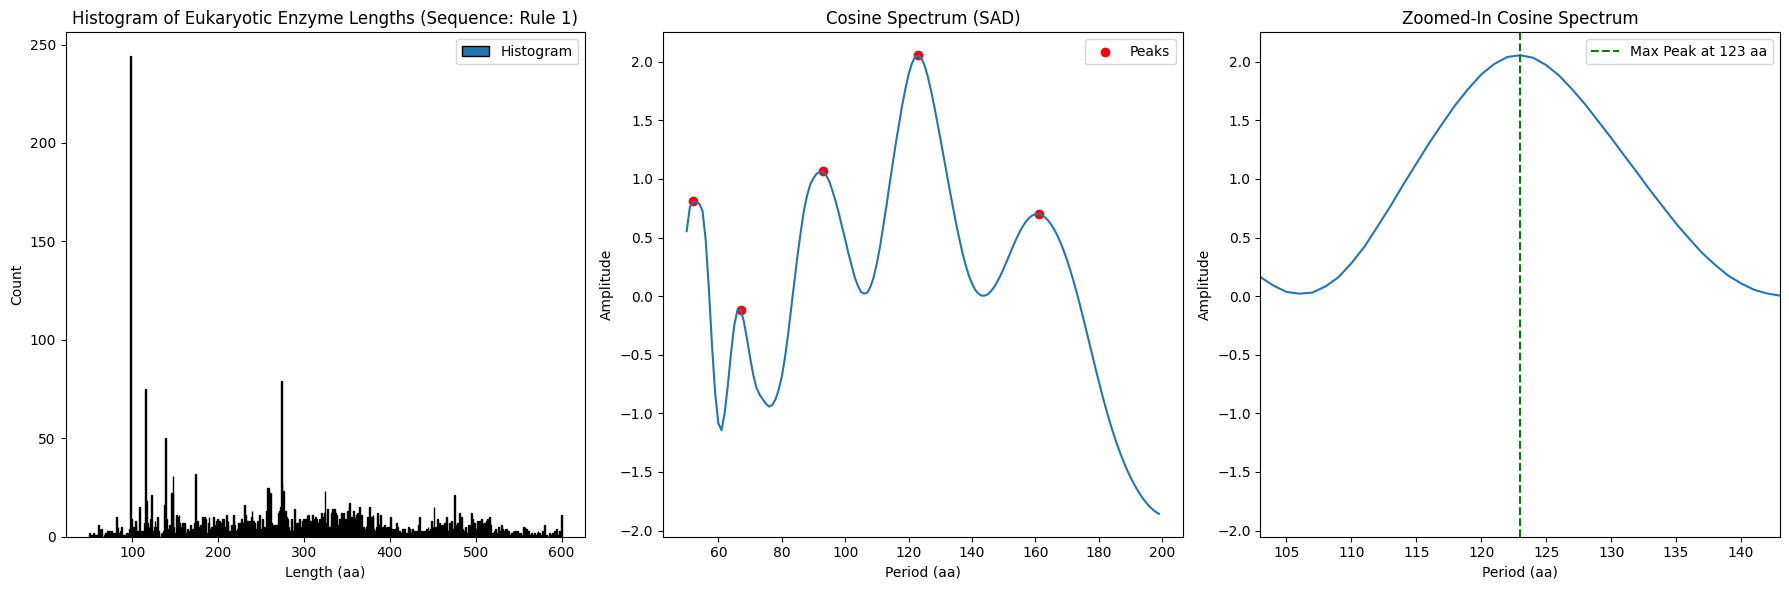

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Detected Peaks:
Period: 52 aa, Amplitude: 0.80774
Period: 67 aa, Amplitude: -0.11688
Period: 93 aa, Amplitude: 1.06397
Period: 123 aa, Amplitude: 2.05573
Period: 161 aa, Amplitude: 0.70022

Maximum Peak Period: 123 aa with Amplitude: 2.05573


In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Load Rule 1 filtered data
filtered_df_rule1 = df_seq_r1

# Step 1: Extract the 'length' column
enzyme_lengths = filtered_df_rule1['length']

# Step 2: Create a histogram (raw counts)
bin_width = 1  # smallest resolution to capture fine oscillations
bins = np.arange(50, 601, bin_width)  # Range: 50–600 aa
hist, bin_edges = np.histogram(enzyme_lengths, bins=bins)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Step 3–4: Generate cosine spectrum using SAD approach
periods = np.arange(50, 200, 1)  # Test periods from 50 to 199 aa
cosine_spectrum = []

for period in periods:
    window = period  # SAD uses a window equal to the period
    half_window = window // 2

    # Moving average smoothing for background
    hist_series = pd.Series(hist)
    background = hist_series.rolling(window=window, center=True, min_periods=1).mean().to_numpy()

    # Oscillating component
    osc = hist - background

    # Define valid index range (avoid edge effects)
    valid = ~np.isnan(background)

    # Cosine projection
    cosine_wave = np.cos(2 * np.pi * bin_centers / period)
    numerator = np.sum(osc[valid] * cosine_wave[valid])
    denominator = np.sum(cosine_wave[valid] ** 2)
    amplitude = numerator / denominator
    cosine_spectrum.append(amplitude)

cosine_spectrum = np.array(cosine_spectrum)

# Step 5: Find peaks in the cosine spectrum
peaks, _ = find_peaks(cosine_spectrum)

# Step 6: Plot results
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Original histogram
axes[0].bar(bin_centers, hist, width=bin_width, edgecolor="black", label="Histogram")
axes[0].set_title("Histogram of Eukaryotic Enzyme Lengths (Sequence: Rule 1)")
axes[0].set_xlabel("Length (aa)")
axes[0].set_ylabel("Count")
axes[0].legend()

# Cosine spectrum
axes[1].plot(periods, cosine_spectrum)
axes[1].scatter(periods[peaks], cosine_spectrum[peaks], color='red', label="Peaks")
axes[1].set_title("Cosine Spectrum (SAD)")
axes[1].set_xlabel("Period (aa)")
axes[1].set_ylabel("Amplitude")
axes[1].legend()

# Zoomed-in cosine spectrum near max peak
peak_periods = periods[peaks]
peak_amplitudes = cosine_spectrum[peaks]
max_peak_idx = np.argmax(peak_amplitudes)
max_period = peak_periods[max_peak_idx]

axes[2].plot(periods, cosine_spectrum)
axes[2].axvline(max_period, color='green', linestyle='--', label=f"Max Peak at {max_period} aa")
axes[2].set_xlim(max_period - 20, max_period + 20)
axes[2].set_title("Zoomed-In Cosine Spectrum")
axes[2].set_xlabel("Period (aa)")
axes[2].set_ylabel("Amplitude")
axes[2].legend()

plt.tight_layout()
plt.savefig("SAD_Sequence_Rule1.png", dpi=300, bbox_inches='tight')
plt.show()

from google.colab import files
files.download('SAD_Sequence_Rule1.png')

# Print detected peaks
print("Detected Peaks:")
for i in range(len(peaks)):
    print(f"Period: {periods[peaks[i]]} aa, Amplitude: {cosine_spectrum[peaks[i]]:.5f}")

print(f"\nMaximum Peak Period: {max_period} aa with Amplitude: {peak_amplitudes[max_peak_idx]:.5f}")

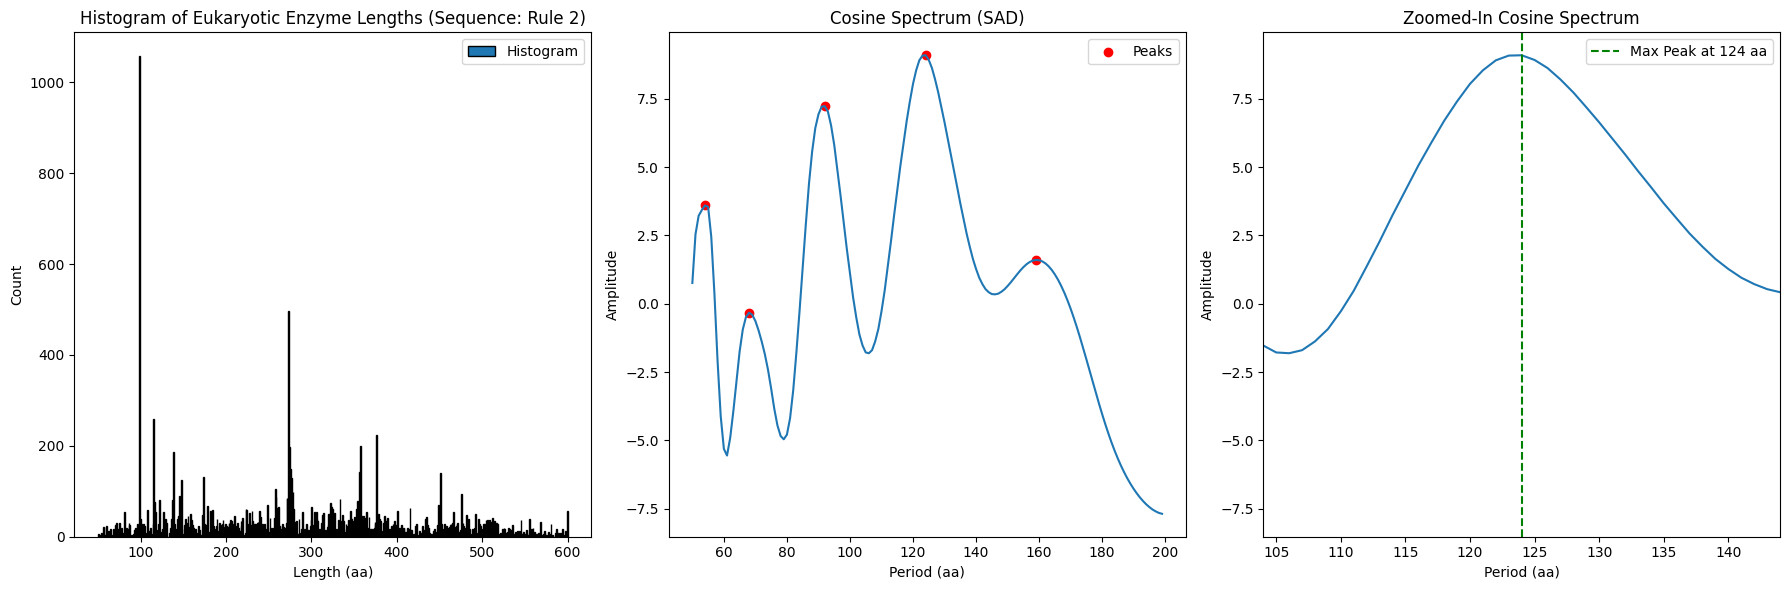

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Detected Peaks:
Period: 54 aa, Amplitude: 3.59558
Period: 68 aa, Amplitude: -0.32929
Period: 92 aa, Amplitude: 7.22766
Period: 124 aa, Amplitude: 9.09293
Period: 159 aa, Amplitude: 1.60021

Maximum Peak Period: 124 aa with Amplitude: 9.09293


In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Load Rule 2 filtered data
filtered_df_rule2 = df_seq_r2

# Step 1: Extract the 'length' column
enzyme_lengths = filtered_df_rule2['length']

# Step 2: Create a histogram (raw counts)
bin_width = 1  # smallest resolution to capture fine oscillations
bins = np.arange(50, 601, bin_width)  # Range: 50–600 aa
hist, bin_edges = np.histogram(enzyme_lengths, bins=bins)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Step 3–4: Generate cosine spectrum using SAD approach
periods = np.arange(50, 200, 1)  # Test periods from 50 to 199 aa
cosine_spectrum = []

for period in periods:
    window = period  # SAD uses a window equal to the period
    half_window = window // 2

    # Moving average smoothing for background
    hist_series = pd.Series(hist)
    background = hist_series.rolling(window=window, center=True, min_periods=1).mean().to_numpy()

    # Oscillating component
    osc = hist - background

    # Define valid index range (avoid edge effects)
    valid = ~np.isnan(background)

    # Cosine projection
    cosine_wave = np.cos(2 * np.pi * bin_centers / period)
    numerator = np.sum(osc[valid] * cosine_wave[valid])
    denominator = np.sum(cosine_wave[valid] ** 2)
    amplitude = numerator / denominator
    cosine_spectrum.append(amplitude)

cosine_spectrum = np.array(cosine_spectrum)

# Step 5: Find peaks in the cosine spectrum
peaks, _ = find_peaks(cosine_spectrum)

# Step 6: Plot results
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Original histogram
axes[0].bar(bin_centers, hist, width=bin_width, edgecolor="black", label="Histogram")
axes[0].set_title("Histogram of Eukaryotic Enzyme Lengths (Sequence: Rule 2)")
axes[0].set_xlabel("Length (aa)")
axes[0].set_ylabel("Count")
axes[0].legend()

# Cosine spectrum
axes[1].plot(periods, cosine_spectrum)
axes[1].scatter(periods[peaks], cosine_spectrum[peaks], color='red', label="Peaks")
axes[1].set_title("Cosine Spectrum (SAD)")
axes[1].set_xlabel("Period (aa)")
axes[1].set_ylabel("Amplitude")
axes[1].legend()

# Zoomed-in cosine spectrum near max peak
peak_periods = periods[peaks]
peak_amplitudes = cosine_spectrum[peaks]
max_peak_idx = np.argmax(peak_amplitudes)
max_period = peak_periods[max_peak_idx]

axes[2].plot(periods, cosine_spectrum)
axes[2].axvline(max_period, color='green', linestyle='--', label=f"Max Peak at {max_period} aa")
axes[2].set_xlim(max_period - 20, max_period + 20)
axes[2].set_title("Zoomed-In Cosine Spectrum")
axes[2].set_xlabel("Period (aa)")
axes[2].set_ylabel("Amplitude")
axes[2].legend()

plt.tight_layout()
plt.savefig("SAD_Sequence_Rule2.png", dpi=300, bbox_inches='tight')
plt.show()

from google.colab import files
files.download('SAD_Sequence_Rule2.png')

# Print detected peaks
print("Detected Peaks:")
for i in range(len(peaks)):
    print(f"Period: {periods[peaks[i]]} aa, Amplitude: {cosine_spectrum[peaks[i]]:.5f}")

print(f"\nMaximum Peak Period: {max_period} aa with Amplitude: {peak_amplitudes[max_peak_idx]:.5f}")

Optimization terminated successfully    (Exit mode 0)
            Current function value: 13963.064666695409
            Iterations: 34
            Function evaluations: 321
            Gradient evaluations: 34


/usr/local/lib/python3.11/dist-packages/scipy/optimize/_slsqp_py.py:434: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

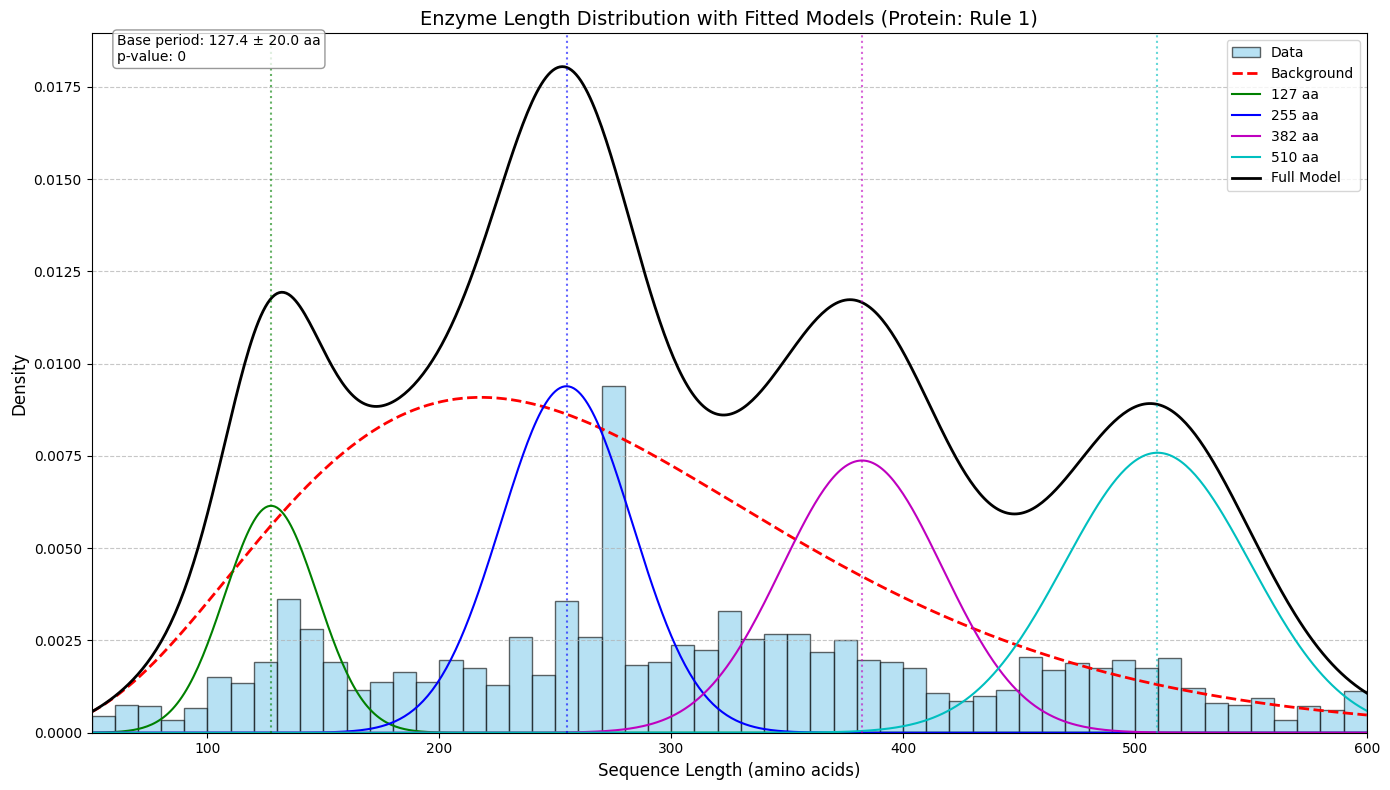

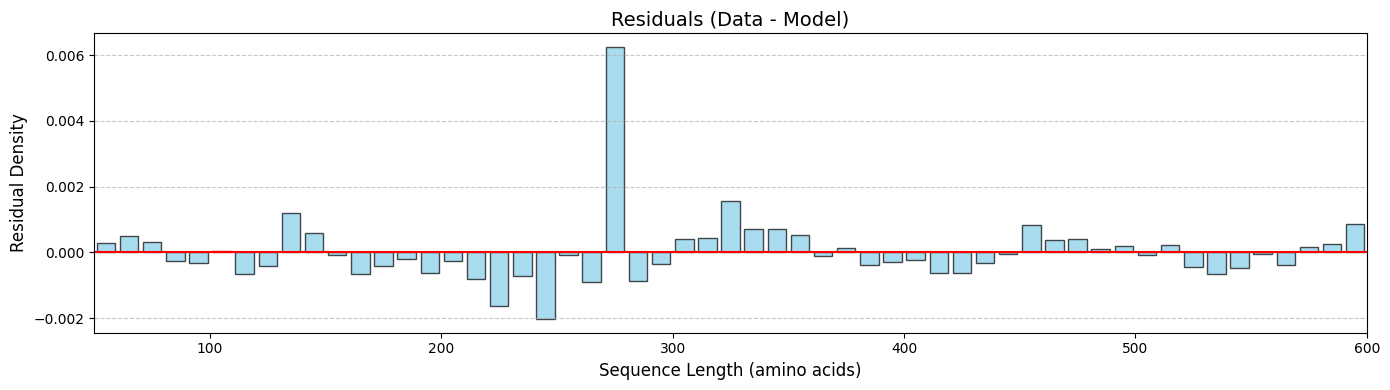

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma, norm, chi2
from scipy.optimize import minimize
from scipy.optimize import LinearConstraint

# Choose dataset: update this line for Rule 1 or Rule 2
df_all = df_prot_r1 # Rule 1

enzyme_lengths = df_all['length'].values

# Step 1: Histogram setup
bin_width = 10
bins = np.arange(enzyme_lengths.min(), enzyme_lengths.max() + bin_width, bin_width)

# Step 2: Log-likelihood functions
def log_likelihood(params, lengths):
    alpha, beta, mu, sigma, p1, p2, p3, p4 = params
    if p1 + p2 + p3 + p4 > 1:
        return np.inf
    background_pdf = gamma.pdf(lengths, alpha, scale=beta)
    peak1_pdf = norm.pdf(lengths, mu, sigma)
    peak2_pdf = norm.pdf(lengths, 2*mu, np.sqrt(2)*sigma)
    peak3_pdf = norm.pdf(lengths, 3*mu, np.sqrt(3)*sigma)
    peak4_pdf = norm.pdf(lengths, 4*mu, np.sqrt(4)*sigma)
    p0 = 1 - (p1 + p2 + p3 + p4)
    mixture_pdf = p0 * background_pdf + p1 * peak1_pdf + p2 * peak2_pdf + p3 * peak3_pdf + p4 * peak4_pdf
    return -np.sum(np.log(mixture_pdf + 1e-10))

def log_likelihood_background_only(params, lengths):
    alpha, beta = params
    background_pdf = gamma.pdf(lengths, alpha, scale=beta)
    return -np.sum(np.log(background_pdf + 1e-10))

# Step 3: Initialization
initial_params = [1.5, 200, 120, 12, 0.05, 0.1, 0.08, 0.07]
bounds = [(0.1, 10), (50, 500), (100, 150), (5, 20),
          (0, 0.3), (0, 0.3), (0, 0.3), (0, 0.3)]
linear_constraint = LinearConstraint([[0, 0, 0, 0, 1, 1, 1, 1]], [0], [1])

# Step 4: Fit full model
result = minimize(log_likelihood, initial_params, args=(enzyme_lengths,),
                  bounds=bounds, constraints=[linear_constraint], method='SLSQP',
                  options={'maxiter': 1000, 'disp': True})
opt_params = result.x
alpha, beta, mu, sigma, p1, p2, p3, p4 = opt_params
p0 = 1 - (p1 + p2 + p3 + p4)

# Step 5: Likelihood ratio test
background_result = minimize(log_likelihood_background_only, [alpha, beta],
                             args=(enzyme_lengths,), bounds=[(0.1, 10), (50, 500)],
                             method='L-BFGS-B')
lrt = 2 * (background_result.fun - result.fun)
p_value = 1 - chi2.cdf(lrt, 6)

# Step 6: Bootstrap
n_bootstrap = 100
bootstrap_params = np.zeros((n_bootstrap, 8))
for i in range(n_bootstrap):
    sample = np.random.choice(enzyme_lengths, size=len(enzyme_lengths), replace=True)
    try:
        res = minimize(log_likelihood, opt_params, args=(sample,), bounds=bounds,
                       constraints=[linear_constraint], method='SLSQP',
                       options={'maxiter': 200})
        bootstrap_params[i] = res.x
    except:
        bootstrap_params[i] = opt_params

lower_ci = np.percentile(bootstrap_params, 2.5, axis=0)
upper_ci = np.percentile(bootstrap_params, 97.5, axis=0)

# Step 7: AIC/BIC
n = len(enzyme_lengths)
AIC_full = 2 * result.fun + 2 * 8
AIC_background = 2 * background_result.fun + 2 * 2
BIC_full = 2 * result.fun + 8 * np.log(n)
BIC_background = 2 * background_result.fun + 2 * np.log(n)

# Step 8: Visualization
x = np.linspace(50, 600, 551)
background_pdf = gamma.pdf(x, alpha, scale=beta)
peak1_pdf = norm.pdf(x, mu, sigma)
peak2_pdf = norm.pdf(x, 2*mu, np.sqrt(2)*sigma)
peak3_pdf = norm.pdf(x, 3*mu, np.sqrt(3)*sigma)
peak4_pdf = norm.pdf(x, 4*mu, np.sqrt(4)*sigma)

plt.figure(figsize=(14, 8))
counts, edges, _ = plt.hist(enzyme_lengths, bins=bins, alpha=0.6, color='skyblue',
                            edgecolor='black', density=True, label='Data')
hist_max = np.max(counts)
pdf_max = max(np.max(p0 * background_pdf), np.max(p1 * peak1_pdf), np.max(p2 * peak2_pdf),
              np.max(p3 * peak3_pdf), np.max(p4 * peak4_pdf))
scale_factor = hist_max / pdf_max if pdf_max > 0 else 1

plt.plot(x, p0 * background_pdf * scale_factor, 'r--', linewidth=2, label='Background')
plt.plot(x, p1 * peak1_pdf * scale_factor, 'g-', linewidth=1.5, label=f'{mu:.0f} aa')
plt.plot(x, p2 * peak2_pdf * scale_factor, 'b-', linewidth=1.5, label=f'{2*mu:.0f} aa')
plt.plot(x, p3 * peak3_pdf * scale_factor, 'm-', linewidth=1.5, label=f'{3*mu:.0f} aa')
plt.plot(x, p4 * peak4_pdf * scale_factor, 'c-', linewidth=1.5, label=f'{4*mu:.0f} aa')
mixture_pdf = (p0 * background_pdf + p1 * peak1_pdf + p2 * peak2_pdf +
               p3 * peak3_pdf + p4 * peak4_pdf) * scale_factor
plt.plot(x, mixture_pdf, 'k-', linewidth=2, label='Full Model')
plt.axvline(x=mu, color='g', linestyle=':', alpha=0.6)
plt.axvline(x=2*mu, color='b', linestyle=':', alpha=0.6)
plt.axvline(x=3*mu, color='m', linestyle=':', alpha=0.6)
plt.axvline(x=4*mu, color='c', linestyle=':', alpha=0.6)
plt.annotate(f"Base period: {mu:.1f} ± {sigma:.1f} aa\np-value: {p_value:.4g}",
             xy=(0.02, 0.96), xycoords='axes fraction',
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8),
             fontsize=10)
plt.title('Enzyme Length Distribution with Fitted Models (Protein: Rule 1)', fontsize=14)
plt.xlabel('Sequence Length (amino acids)', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xlim(50, 600)
plt.tight_layout()
plt.savefig("Statistical_Model_Output_Protein_Rule1.png", dpi=300, bbox_inches='tight')

from google.colab import files
files.download('Statistical_Model_Output_Protein_Rule1.png')

# Residual plot
plt.figure(figsize=(14, 4))
hist_centers = (edges[:-1] + edges[1:]) / 2
hist_values, _ = np.histogram(enzyme_lengths, bins=bins, density=True)
model_at_bins = np.interp(hist_centers, x, mixture_pdf / scale_factor)
residuals = hist_values - model_at_bins
plt.bar(hist_centers, residuals, width=bin_width*0.8, color='skyblue', edgecolor='black', alpha=0.7)
plt.axhline(y=0, color='r', linestyle='-')
plt.title('Residuals (Data - Model)', fontsize=14)
plt.xlabel('Sequence Length (amino acids)', fontsize=12)
plt.ylabel('Residual Density', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xlim(50, 600)
plt.tight_layout()
plt.savefig("Statistical_Model_Residuals_Protein_Rule1.png", dpi=300, bbox_inches='tight')
plt.show()

from google.colab import files
files.download('Statistical_Model_Residuals_Protein_Rule1.png')

Optimization terminated successfully    (Exit mode 0)
            Current function value: 100997.83832513102
            Iterations: 28
            Function evaluations: 270
            Gradient evaluations: 28


/usr/local/lib/python3.11/dist-packages/scipy/optimize/_slsqp_py.py:434: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

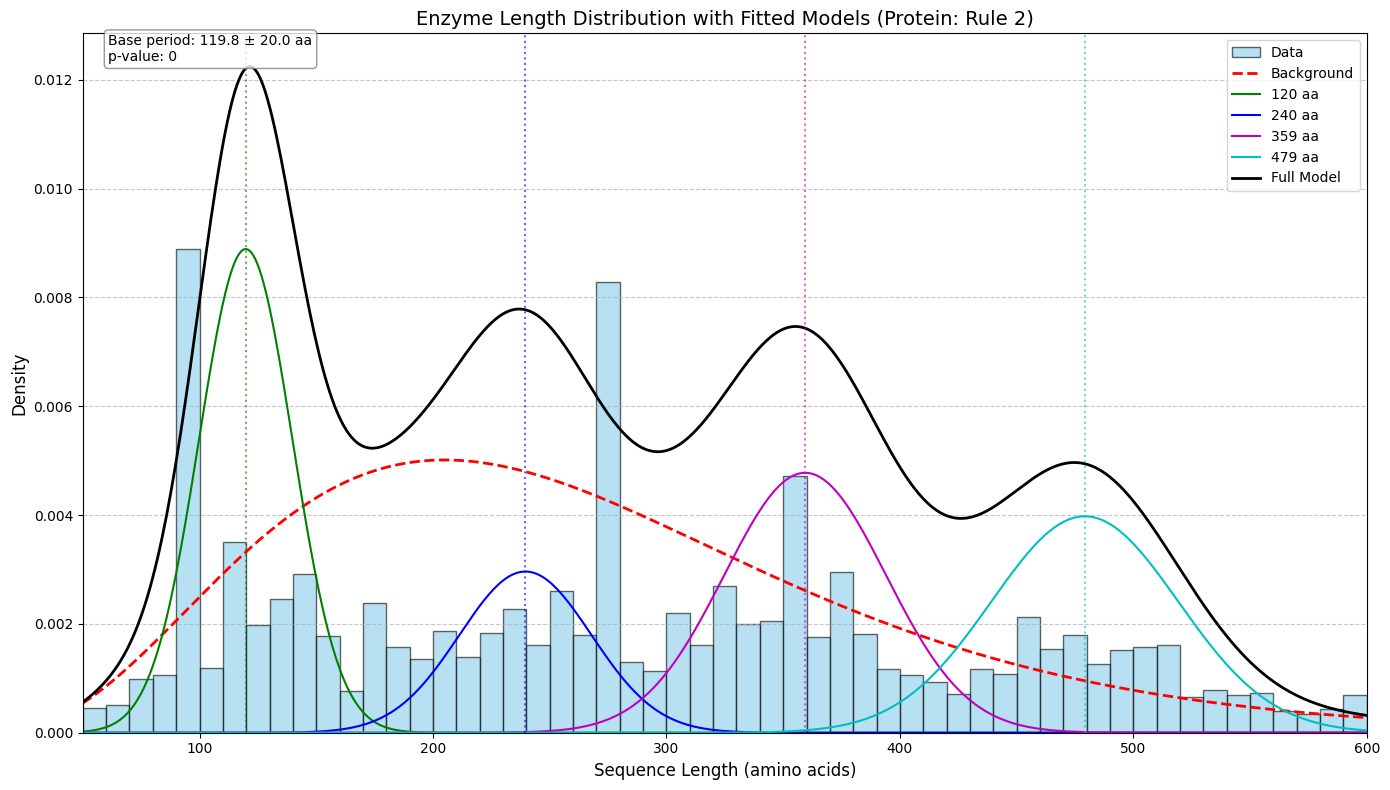

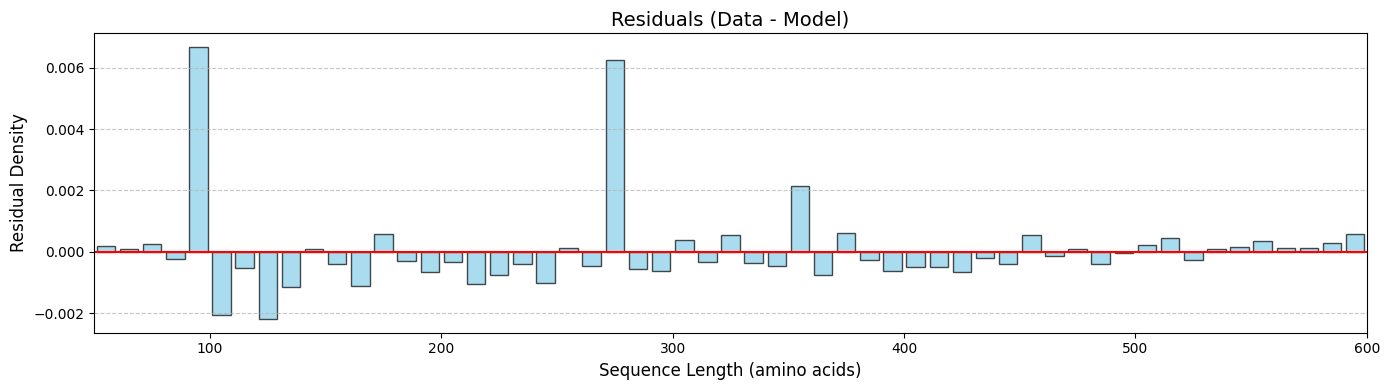

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma, norm, chi2
from scipy.optimize import minimize
from scipy.optimize import LinearConstraint

# Choose dataset: update this line for Rule 1 or Rule 2
df_all = df_prot_r2  # for Rule 2

enzyme_lengths = df_all['length'].values

# Step 1: Histogram setup
bin_width = 10
bins = np.arange(enzyme_lengths.min(), enzyme_lengths.max() + bin_width, bin_width)

# Step 2: Log-likelihood functions
def log_likelihood(params, lengths):
    alpha, beta, mu, sigma, p1, p2, p3, p4 = params
    if p1 + p2 + p3 + p4 > 1:
        return np.inf
    background_pdf = gamma.pdf(lengths, alpha, scale=beta)
    peak1_pdf = norm.pdf(lengths, mu, sigma)
    peak2_pdf = norm.pdf(lengths, 2*mu, np.sqrt(2)*sigma)
    peak3_pdf = norm.pdf(lengths, 3*mu, np.sqrt(3)*sigma)
    peak4_pdf = norm.pdf(lengths, 4*mu, np.sqrt(4)*sigma)
    p0 = 1 - (p1 + p2 + p3 + p4)
    mixture_pdf = p0 * background_pdf + p1 * peak1_pdf + p2 * peak2_pdf + p3 * peak3_pdf + p4 * peak4_pdf
    return -np.sum(np.log(mixture_pdf + 1e-10))

def log_likelihood_background_only(params, lengths):
    alpha, beta = params
    background_pdf = gamma.pdf(lengths, alpha, scale=beta)
    return -np.sum(np.log(background_pdf + 1e-10))

# Step 3: Initialization
initial_params = [1.5, 200, 120, 12, 0.05, 0.1, 0.08, 0.07]
bounds = [(0.1, 10), (50, 500), (100, 150), (5, 20),
          (0, 0.3), (0, 0.3), (0, 0.3), (0, 0.3)]
linear_constraint = LinearConstraint([[0, 0, 0, 0, 1, 1, 1, 1]], [0], [1])

# Step 4: Fit full model
result = minimize(log_likelihood, initial_params, args=(enzyme_lengths,),
                  bounds=bounds, constraints=[linear_constraint], method='SLSQP',
                  options={'maxiter': 1000, 'disp': True})
opt_params = result.x
alpha, beta, mu, sigma, p1, p2, p3, p4 = opt_params
p0 = 1 - (p1 + p2 + p3 + p4)

# Step 5: Likelihood ratio test
background_result = minimize(log_likelihood_background_only, [alpha, beta],
                             args=(enzyme_lengths,), bounds=[(0.1, 10), (50, 500)],
                             method='L-BFGS-B')
lrt = 2 * (background_result.fun - result.fun)
p_value = 1 - chi2.cdf(lrt, 6)

# Step 6: Bootstrap
n_bootstrap = 100
bootstrap_params = np.zeros((n_bootstrap, 8))
for i in range(n_bootstrap):
    sample = np.random.choice(enzyme_lengths, size=len(enzyme_lengths), replace=True)
    try:
        res = minimize(log_likelihood, opt_params, args=(sample,), bounds=bounds,
                       constraints=[linear_constraint], method='SLSQP',
                       options={'maxiter': 200})
        bootstrap_params[i] = res.x
    except:
        bootstrap_params[i] = opt_params

lower_ci = np.percentile(bootstrap_params, 2.5, axis=0)
upper_ci = np.percentile(bootstrap_params, 97.5, axis=0)

# Step 7: AIC/BIC
n = len(enzyme_lengths)
AIC_full = 2 * result.fun + 2 * 8
AIC_background = 2 * background_result.fun + 2 * 2
BIC_full = 2 * result.fun + 8 * np.log(n)
BIC_background = 2 * background_result.fun + 2 * np.log(n)

# Step 8: Visualization
x = np.linspace(50, 600, 551)
background_pdf = gamma.pdf(x, alpha, scale=beta)
peak1_pdf = norm.pdf(x, mu, sigma)
peak2_pdf = norm.pdf(x, 2*mu, np.sqrt(2)*sigma)
peak3_pdf = norm.pdf(x, 3*mu, np.sqrt(3)*sigma)
peak4_pdf = norm.pdf(x, 4*mu, np.sqrt(4)*sigma)

plt.figure(figsize=(14, 8))
counts, edges, _ = plt.hist(enzyme_lengths, bins=bins, alpha=0.6, color='skyblue',
                            edgecolor='black', density=True, label='Data')
hist_max = np.max(counts)
pdf_max = max(np.max(p0 * background_pdf), np.max(p1 * peak1_pdf), np.max(p2 * peak2_pdf),
              np.max(p3 * peak3_pdf), np.max(p4 * peak4_pdf))
scale_factor = hist_max / pdf_max if pdf_max > 0 else 1

plt.plot(x, p0 * background_pdf * scale_factor, 'r--', linewidth=2, label='Background')
plt.plot(x, p1 * peak1_pdf * scale_factor, 'g-', linewidth=1.5, label=f'{mu:.0f} aa')
plt.plot(x, p2 * peak2_pdf * scale_factor, 'b-', linewidth=1.5, label=f'{2*mu:.0f} aa')
plt.plot(x, p3 * peak3_pdf * scale_factor, 'm-', linewidth=1.5, label=f'{3*mu:.0f} aa')
plt.plot(x, p4 * peak4_pdf * scale_factor, 'c-', linewidth=1.5, label=f'{4*mu:.0f} aa')
mixture_pdf = (p0 * background_pdf + p1 * peak1_pdf + p2 * peak2_pdf +
               p3 * peak3_pdf + p4 * peak4_pdf) * scale_factor
plt.plot(x, mixture_pdf, 'k-', linewidth=2, label='Full Model')
plt.axvline(x=mu, color='g', linestyle=':', alpha=0.6)
plt.axvline(x=2*mu, color='b', linestyle=':', alpha=0.6)
plt.axvline(x=3*mu, color='m', linestyle=':', alpha=0.6)
plt.axvline(x=4*mu, color='c', linestyle=':', alpha=0.6)
plt.annotate(f"Base period: {mu:.1f} ± {sigma:.1f} aa\np-value: {p_value:.4g}",
             xy=(0.02, 0.96), xycoords='axes fraction',
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8),
             fontsize=10)
plt.title('Enzyme Length Distribution with Fitted Models (Protein: Rule 2)', fontsize=14)
plt.xlabel('Sequence Length (amino acids)', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xlim(50, 600)
plt.tight_layout()
plt.savefig("Statistical_Model_Output_Protein_Rule2.png", dpi=300, bbox_inches='tight')

from google.colab import files
files.download('Statistical_Model_Output_Protein_Rule2.png')

# Residual plot
plt.figure(figsize=(14, 4))
hist_centers = (edges[:-1] + edges[1:]) / 2
hist_values, _ = np.histogram(enzyme_lengths, bins=bins, density=True)
model_at_bins = np.interp(hist_centers, x, mixture_pdf / scale_factor)
residuals = hist_values - model_at_bins
plt.bar(hist_centers, residuals, width=bin_width*0.8, color='skyblue', edgecolor='black', alpha=0.7)
plt.axhline(y=0, color='r', linestyle='-')
plt.title('Residuals (Data - Model)', fontsize=14)
plt.xlabel('Sequence Length (amino acids)', fontsize=12)
plt.ylabel('Residual Density', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xlim(50, 600)
plt.tight_layout()
plt.savefig("Statistical_Model_Residuals_Protein_Rule2.png", dpi=300, bbox_inches='tight')
plt.show()

from google.colab import files
files.download('Statistical_Model_Residuals_Protein_Rule2.png')

Optimization terminated successfully    (Exit mode 0)
            Current function value: 21430.901035543946
            Iterations: 37
            Function evaluations: 353
            Gradient evaluations: 37


/usr/local/lib/python3.11/dist-packages/scipy/optimize/_slsqp_py.py:434: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

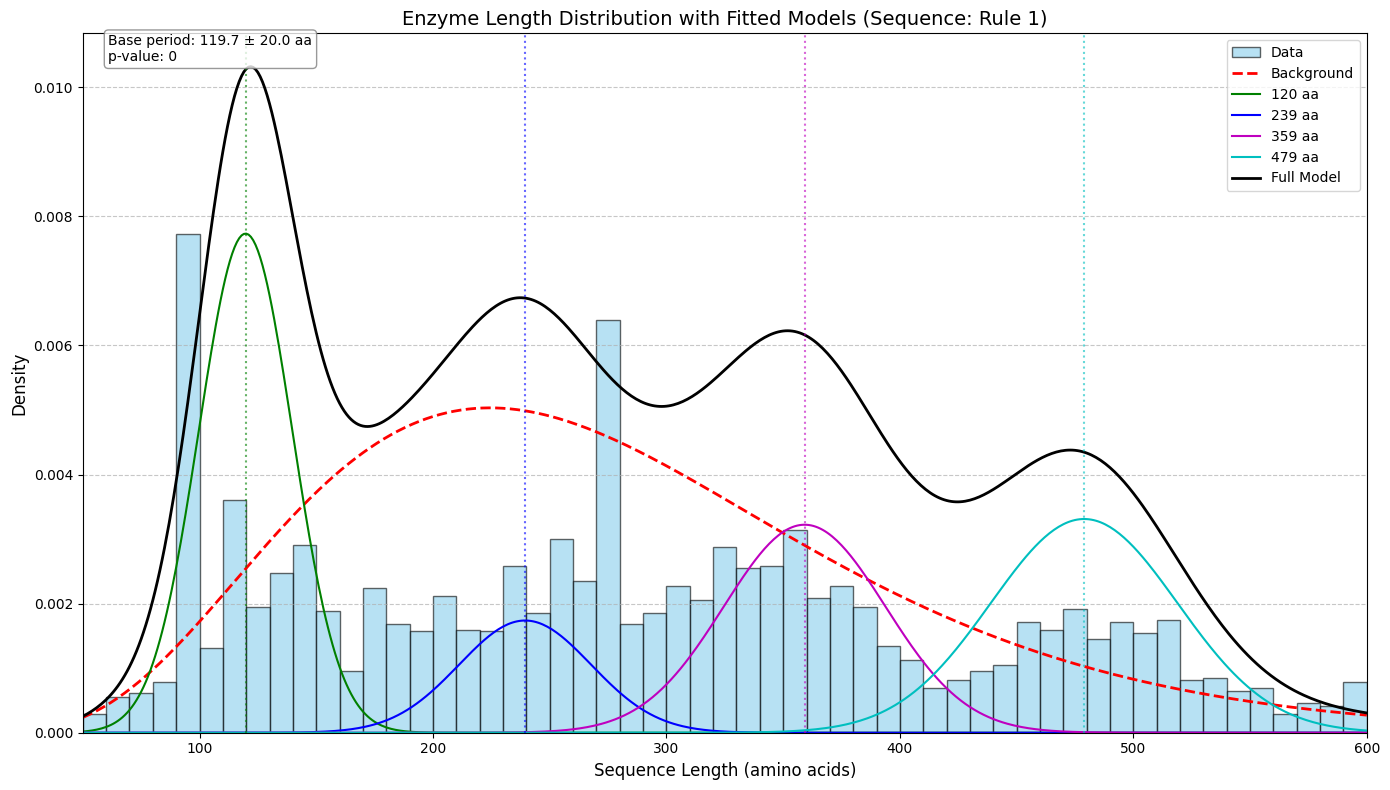

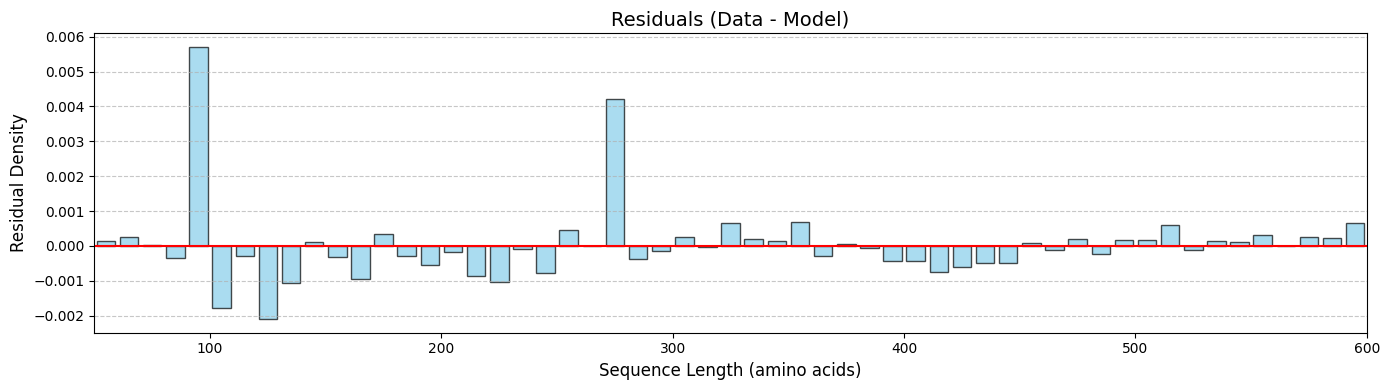

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma, norm, chi2
from scipy.optimize import minimize
from scipy.optimize import LinearConstraint

# Choose dataset: update this line for Rule 1 or Rule 2
df_all = df_seq_r1  # for Rule 1

enzyme_lengths = df_all['length'].values

# Step 1: Histogram setup
bin_width = 10
bins = np.arange(enzyme_lengths.min(), enzyme_lengths.max() + bin_width, bin_width)

# Step 2: Log-likelihood functions
def log_likelihood(params, lengths):
    alpha, beta, mu, sigma, p1, p2, p3, p4 = params
    if p1 + p2 + p3 + p4 > 1:
        return np.inf
    background_pdf = gamma.pdf(lengths, alpha, scale=beta)
    peak1_pdf = norm.pdf(lengths, mu, sigma)
    peak2_pdf = norm.pdf(lengths, 2*mu, np.sqrt(2)*sigma)
    peak3_pdf = norm.pdf(lengths, 3*mu, np.sqrt(3)*sigma)
    peak4_pdf = norm.pdf(lengths, 4*mu, np.sqrt(4)*sigma)
    p0 = 1 - (p1 + p2 + p3 + p4)
    mixture_pdf = p0 * background_pdf + p1 * peak1_pdf + p2 * peak2_pdf + p3 * peak3_pdf + p4 * peak4_pdf
    return -np.sum(np.log(mixture_pdf + 1e-10))

def log_likelihood_background_only(params, lengths):
    alpha, beta = params
    background_pdf = gamma.pdf(lengths, alpha, scale=beta)
    return -np.sum(np.log(background_pdf + 1e-10))

# Step 3: Initialization
initial_params = [1.5, 200, 120, 12, 0.05, 0.1, 0.08, 0.07]
bounds = [(0.1, 10), (50, 500), (100, 150), (5, 20),
          (0, 0.3), (0, 0.3), (0, 0.3), (0, 0.3)]
linear_constraint = LinearConstraint([[0, 0, 0, 0, 1, 1, 1, 1]], [0], [1])

# Step 4: Fit full model
result = minimize(log_likelihood, initial_params, args=(enzyme_lengths,),
                  bounds=bounds, constraints=[linear_constraint], method='SLSQP',
                  options={'maxiter': 1000, 'disp': True})
opt_params = result.x
alpha, beta, mu, sigma, p1, p2, p3, p4 = opt_params
p0 = 1 - (p1 + p2 + p3 + p4)

# Step 5: Likelihood ratio test
background_result = minimize(log_likelihood_background_only, [alpha, beta],
                             args=(enzyme_lengths,), bounds=[(0.1, 10), (50, 500)],
                             method='L-BFGS-B')
lrt = 2 * (background_result.fun - result.fun)
p_value = 1 - chi2.cdf(lrt, 6)

# Step 6: Bootstrap
n_bootstrap = 100
bootstrap_params = np.zeros((n_bootstrap, 8))
for i in range(n_bootstrap):
    sample = np.random.choice(enzyme_lengths, size=len(enzyme_lengths), replace=True)
    try:
        res = minimize(log_likelihood, opt_params, args=(sample,), bounds=bounds,
                       constraints=[linear_constraint], method='SLSQP',
                       options={'maxiter': 200})
        bootstrap_params[i] = res.x
    except:
        bootstrap_params[i] = opt_params

lower_ci = np.percentile(bootstrap_params, 2.5, axis=0)
upper_ci = np.percentile(bootstrap_params, 97.5, axis=0)

# Step 7: AIC/BIC
n = len(enzyme_lengths)
AIC_full = 2 * result.fun + 2 * 8
AIC_background = 2 * background_result.fun + 2 * 2
BIC_full = 2 * result.fun + 8 * np.log(n)
BIC_background = 2 * background_result.fun + 2 * np.log(n)

# Step 8: Visualization
x = np.linspace(50, 600, 551)
background_pdf = gamma.pdf(x, alpha, scale=beta)
peak1_pdf = norm.pdf(x, mu, sigma)
peak2_pdf = norm.pdf(x, 2*mu, np.sqrt(2)*sigma)
peak3_pdf = norm.pdf(x, 3*mu, np.sqrt(3)*sigma)
peak4_pdf = norm.pdf(x, 4*mu, np.sqrt(4)*sigma)

plt.figure(figsize=(14, 8))
counts, edges, _ = plt.hist(enzyme_lengths, bins=bins, alpha=0.6, color='skyblue',
                            edgecolor='black', density=True, label='Data')
hist_max = np.max(counts)
pdf_max = max(np.max(p0 * background_pdf), np.max(p1 * peak1_pdf), np.max(p2 * peak2_pdf),
              np.max(p3 * peak3_pdf), np.max(p4 * peak4_pdf))
scale_factor = hist_max / pdf_max if pdf_max > 0 else 1

plt.plot(x, p0 * background_pdf * scale_factor, 'r--', linewidth=2, label='Background')
plt.plot(x, p1 * peak1_pdf * scale_factor, 'g-', linewidth=1.5, label=f'{mu:.0f} aa')
plt.plot(x, p2 * peak2_pdf * scale_factor, 'b-', linewidth=1.5, label=f'{2*mu:.0f} aa')
plt.plot(x, p3 * peak3_pdf * scale_factor, 'm-', linewidth=1.5, label=f'{3*mu:.0f} aa')
plt.plot(x, p4 * peak4_pdf * scale_factor, 'c-', linewidth=1.5, label=f'{4*mu:.0f} aa')
mixture_pdf = (p0 * background_pdf + p1 * peak1_pdf + p2 * peak2_pdf +
               p3 * peak3_pdf + p4 * peak4_pdf) * scale_factor
plt.plot(x, mixture_pdf, 'k-', linewidth=2, label='Full Model')
plt.axvline(x=mu, color='g', linestyle=':', alpha=0.6)
plt.axvline(x=2*mu, color='b', linestyle=':', alpha=0.6)
plt.axvline(x=3*mu, color='m', linestyle=':', alpha=0.6)
plt.axvline(x=4*mu, color='c', linestyle=':', alpha=0.6)
plt.annotate(f"Base period: {mu:.1f} ± {sigma:.1f} aa\np-value: {p_value:.4g}",
             xy=(0.02, 0.96), xycoords='axes fraction',
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8),
             fontsize=10)
plt.title('Enzyme Length Distribution with Fitted Models (Sequence: Rule 1)', fontsize=14)
plt.xlabel('Sequence Length (amino acids)', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xlim(50, 600)
plt.tight_layout()
plt.savefig("Statistical_Model_Output_Sequence_Rule1.png", dpi=300, bbox_inches='tight')

from google.colab import files
files.download('Statistical_Model_Output_Sequence_Rule1.png')

# Residual plot
plt.figure(figsize=(14, 4))
hist_centers = (edges[:-1] + edges[1:]) / 2
hist_values, _ = np.histogram(enzyme_lengths, bins=bins, density=True)
model_at_bins = np.interp(hist_centers, x, mixture_pdf / scale_factor)
residuals = hist_values - model_at_bins
plt.bar(hist_centers, residuals, width=bin_width*0.8, color='skyblue', edgecolor='black', alpha=0.7)
plt.axhline(y=0, color='r', linestyle='-')
plt.title('Residuals (Data - Model)', fontsize=14)
plt.xlabel('Sequence Length (amino acids)', fontsize=12)
plt.ylabel('Residual Density', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xlim(50, 600)
plt.tight_layout()
plt.savefig("Statistical_Model_Residuals_Sequence_Rule1.png", dpi=300, bbox_inches='tight')
plt.show()

from google.colab import files
files.download('Statistical_Model_Residuals_Sequence_Rule1.png')

Optimization terminated successfully    (Exit mode 0)
            Current function value: 94288.87761023629
            Iterations: 26
            Function evaluations: 248
            Gradient evaluations: 25


/usr/local/lib/python3.11/dist-packages/scipy/optimize/_slsqp_py.py:434: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

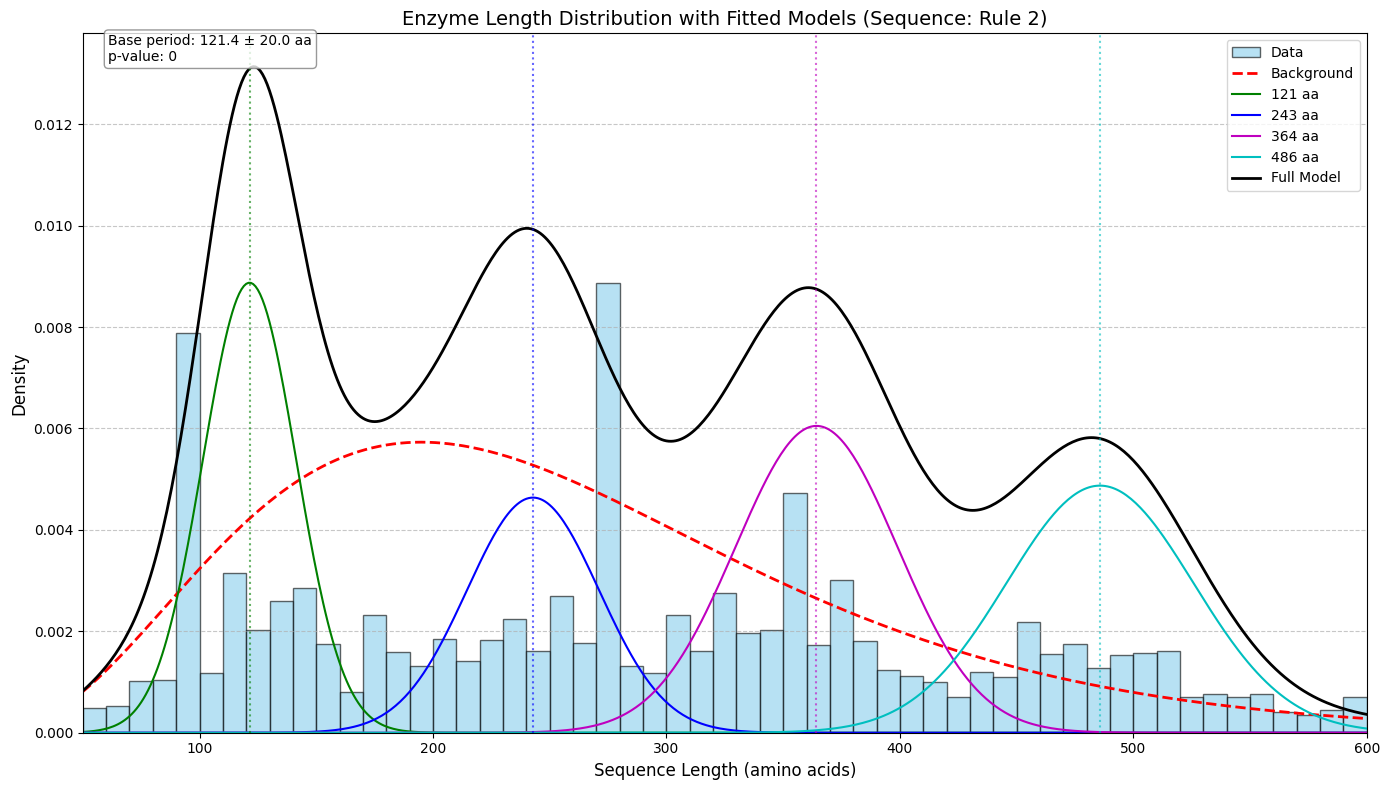

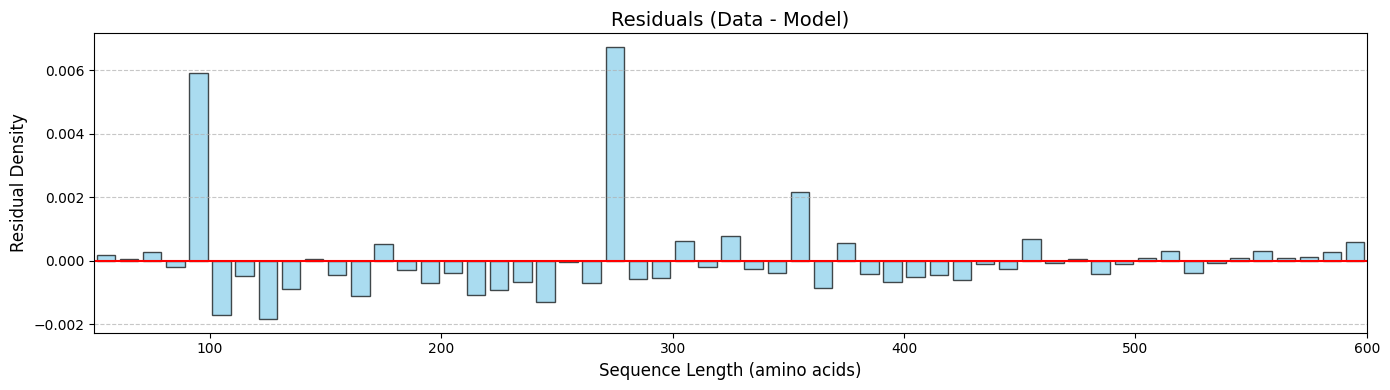

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma, norm, chi2
from scipy.optimize import minimize
from scipy.optimize import LinearConstraint

# Choose dataset: update this line for Rule 1 or Rule 2
df_all = df_seq_r2  # for Rule 1

enzyme_lengths = df_all['length'].values

# Step 1: Histogram setup
bin_width = 10
bins = np.arange(enzyme_lengths.min(), enzyme_lengths.max() + bin_width, bin_width)

# Step 2: Log-likelihood functions
def log_likelihood(params, lengths):
    alpha, beta, mu, sigma, p1, p2, p3, p4 = params
    if p1 + p2 + p3 + p4 > 1:
        return np.inf
    background_pdf = gamma.pdf(lengths, alpha, scale=beta)
    peak1_pdf = norm.pdf(lengths, mu, sigma)
    peak2_pdf = norm.pdf(lengths, 2*mu, np.sqrt(2)*sigma)
    peak3_pdf = norm.pdf(lengths, 3*mu, np.sqrt(3)*sigma)
    peak4_pdf = norm.pdf(lengths, 4*mu, np.sqrt(4)*sigma)
    p0 = 1 - (p1 + p2 + p3 + p4)
    mixture_pdf = p0 * background_pdf + p1 * peak1_pdf + p2 * peak2_pdf + p3 * peak3_pdf + p4 * peak4_pdf
    return -np.sum(np.log(mixture_pdf + 1e-10))

def log_likelihood_background_only(params, lengths):
    alpha, beta = params
    background_pdf = gamma.pdf(lengths, alpha, scale=beta)
    return -np.sum(np.log(background_pdf + 1e-10))

# Step 3: Initialization
initial_params = [1.5, 200, 120, 12, 0.05, 0.1, 0.08, 0.07]
bounds = [(0.1, 10), (50, 500), (100, 150), (5, 20),
          (0, 0.3), (0, 0.3), (0, 0.3), (0, 0.3)]
linear_constraint = LinearConstraint([[0, 0, 0, 0, 1, 1, 1, 1]], [0], [1])

# Step 4: Fit full model
result = minimize(log_likelihood, initial_params, args=(enzyme_lengths,),
                  bounds=bounds, constraints=[linear_constraint], method='SLSQP',
                  options={'maxiter': 1000, 'disp': True})
opt_params = result.x
alpha, beta, mu, sigma, p1, p2, p3, p4 = opt_params
p0 = 1 - (p1 + p2 + p3 + p4)

# Step 5: Likelihood ratio test
background_result = minimize(log_likelihood_background_only, [alpha, beta],
                             args=(enzyme_lengths,), bounds=[(0.1, 10), (50, 500)],
                             method='L-BFGS-B')
lrt = 2 * (background_result.fun - result.fun)
p_value = 1 - chi2.cdf(lrt, 6)

# Step 6: Bootstrap
n_bootstrap = 100
bootstrap_params = np.zeros((n_bootstrap, 8))
for i in range(n_bootstrap):
    sample = np.random.choice(enzyme_lengths, size=len(enzyme_lengths), replace=True)
    try:
        res = minimize(log_likelihood, opt_params, args=(sample,), bounds=bounds,
                       constraints=[linear_constraint], method='SLSQP',
                       options={'maxiter': 200})
        bootstrap_params[i] = res.x
    except:
        bootstrap_params[i] = opt_params

lower_ci = np.percentile(bootstrap_params, 2.5, axis=0)
upper_ci = np.percentile(bootstrap_params, 97.5, axis=0)

# Step 7: AIC/BIC
n = len(enzyme_lengths)
AIC_full = 2 * result.fun + 2 * 8
AIC_background = 2 * background_result.fun + 2 * 2
BIC_full = 2 * result.fun + 8 * np.log(n)
BIC_background = 2 * background_result.fun + 2 * np.log(n)

# Step 8: Visualization
x = np.linspace(50, 600, 551)
background_pdf = gamma.pdf(x, alpha, scale=beta)
peak1_pdf = norm.pdf(x, mu, sigma)
peak2_pdf = norm.pdf(x, 2*mu, np.sqrt(2)*sigma)
peak3_pdf = norm.pdf(x, 3*mu, np.sqrt(3)*sigma)
peak4_pdf = norm.pdf(x, 4*mu, np.sqrt(4)*sigma)

plt.figure(figsize=(14, 8))
counts, edges, _ = plt.hist(enzyme_lengths, bins=bins, alpha=0.6, color='skyblue',
                            edgecolor='black', density=True, label='Data')
hist_max = np.max(counts)
pdf_max = max(np.max(p0 * background_pdf), np.max(p1 * peak1_pdf), np.max(p2 * peak2_pdf),
              np.max(p3 * peak3_pdf), np.max(p4 * peak4_pdf))
scale_factor = hist_max / pdf_max if pdf_max > 0 else 1

plt.plot(x, p0 * background_pdf * scale_factor, 'r--', linewidth=2, label='Background')
plt.plot(x, p1 * peak1_pdf * scale_factor, 'g-', linewidth=1.5, label=f'{mu:.0f} aa')
plt.plot(x, p2 * peak2_pdf * scale_factor, 'b-', linewidth=1.5, label=f'{2*mu:.0f} aa')
plt.plot(x, p3 * peak3_pdf * scale_factor, 'm-', linewidth=1.5, label=f'{3*mu:.0f} aa')
plt.plot(x, p4 * peak4_pdf * scale_factor, 'c-', linewidth=1.5, label=f'{4*mu:.0f} aa')
mixture_pdf = (p0 * background_pdf + p1 * peak1_pdf + p2 * peak2_pdf +
               p3 * peak3_pdf + p4 * peak4_pdf) * scale_factor
plt.plot(x, mixture_pdf, 'k-', linewidth=2, label='Full Model')
plt.axvline(x=mu, color='g', linestyle=':', alpha=0.6)
plt.axvline(x=2*mu, color='b', linestyle=':', alpha=0.6)
plt.axvline(x=3*mu, color='m', linestyle=':', alpha=0.6)
plt.axvline(x=4*mu, color='c', linestyle=':', alpha=0.6)
plt.annotate(f"Base period: {mu:.1f} ± {sigma:.1f} aa\np-value: {p_value:.4g}",
             xy=(0.02, 0.96), xycoords='axes fraction',
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8),
             fontsize=10)
plt.title('Enzyme Length Distribution with Fitted Models (Sequence: Rule 2)', fontsize=14)
plt.xlabel('Sequence Length (amino acids)', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xlim(50, 600)
plt.tight_layout()
plt.savefig("Statistical_Model_Output_Sequence_Rule2.png", dpi=300, bbox_inches='tight')

from google.colab import files
files.download('Statistical_Model_Output_Sequence_Rule2.png')

# Residual plot
plt.figure(figsize=(14, 4))
hist_centers = (edges[:-1] + edges[1:]) / 2
hist_values, _ = np.histogram(enzyme_lengths, bins=bins, density=True)
model_at_bins = np.interp(hist_centers, x, mixture_pdf / scale_factor)
residuals = hist_values - model_at_bins
plt.bar(hist_centers, residuals, width=bin_width*0.8, color='skyblue', edgecolor='black', alpha=0.7)
plt.axhline(y=0, color='r', linestyle='-')
plt.title('Residuals (Data - Model)', fontsize=14)
plt.xlabel('Sequence Length (amino acids)', fontsize=12)
plt.ylabel('Residual Density', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xlim(50, 600)
plt.tight_layout()
plt.savefig("Statistical_Model_Residuals_Sequence_Rule2.png", dpi=300, bbox_inches='tight')
plt.show()

from google.colab import files
files.download('Statistical_Model_Residuals_Sequence_Rule2.png')

In [41]:
from scipy.stats import chi2
import numpy as np

# Use: opt_params, result.fun, background_result.fun, and enzyme_lengths from your previous steps

# Extract values
alpha, beta, mu, sigma, p1, p2, p3, p4 = opt_params
p0 = 1 - (p1 + p2 + p3 + p4)

print(f"\n✅ Optimization Successful: {result.success}, message: {result.message}")

print("\n🔢 Optimized Parameters:")
print(f"  Gamma (background): alpha = {alpha:.2f}, beta = {beta:.2f} → weight = {p0:.4f}")
print(f"  Periodic peaks at μ = {mu:.2f} (σ = {sigma:.2f})")
print(f"  Peak weights: p1 = {p1:.4f}, p2 = {p2:.4f}, p3 = {p3:.4f}, p4 = {p4:.4f}")

# Likelihood Ratio Test
lrt_stat = 2 * (background_result.fun - result.fun)
dof = 6  # 8 - 2 parameters
p_value = 1 - chi2.cdf(lrt_stat, dof)

print(f"\n📊 Likelihood Ratio Test:")
print(f"  LRT statistic: {lrt_stat:.2f}")
print(f"  p-value: {p_value:.8f}")

if p_value < 0.05:
    print("✅ Periodicity is statistically significant (p < 0.05)")
else:
    print("❌ Periodicity is not statistically significant (p ≥ 0.05)")

# AIC / BIC
n_params_full = 8
n_params_background = 2
n = len(enzyme_lengths)

AIC_full = 2 * result.fun + 2 * n_params_full
AIC_background = 2 * background_result.fun + 2 * n_params_background

BIC_full = 2 * result.fun + n_params_full * np.log(n)
BIC_background = 2 * background_result.fun + n_params_background * np.log(n)

print(f"\n📈 Model Fit Comparison:")
print(f"  Full Model     — AIC: {AIC_full:.2f}, BIC: {BIC_full:.2f}")
print(f"  Background Only — AIC: {AIC_background:.2f}, BIC: {BIC_background:.2f}")

if AIC_full < AIC_background:
    print("✅ Full model preferred by AIC")
else:
    print("❌ Background-only model preferred by AIC")

if BIC_full < BIC_background:
    print("✅ Full model preferred by BIC")
else:
    print("❌ Background-only model preferred by BIC")

# Bootstrap 95% CI
print("\n📌 95% Confidence Intervals (from bootstrap):")
param_names = ["alpha", "beta", "mu", "sigma", "p1", "p2", "p3", "p4"]
lower_ci = np.percentile(bootstrap_params, 2.5, axis=0)
upper_ci = np.percentile(bootstrap_params, 97.5, axis=0)

for i, name in enumerate(param_names):
    print(f"  {name}: {opt_params[i]:.4f} (95% CI: {lower_ci[i]:.4f} – {upper_ci[i]:.4f})")



✅ Optimization Successful: True, message: Optimization terminated successfully

🔢 Optimized Parameters:
  Gamma (background): alpha = 4.17, beta = 61.50 → weight = 0.4745
  Periodic peaks at μ = 121.43 (σ = 20.00)
  Peak weights: p1 = 0.1308, p2 = 0.0966, p3 = 0.1544, p4 = 0.1436

📊 Likelihood Ratio Test:
  LRT statistic: 2207.13
  p-value: 0.00000000
✅ Periodicity is statistically significant (p < 0.05)

📈 Model Fit Comparison:
  Full Model     — AIC: 188593.76, BIC: 188654.74
  Background Only — AIC: 190788.88, BIC: 190804.13
✅ Full model preferred by AIC
✅ Full model preferred by BIC

📌 95% Confidence Intervals (from bootstrap):
  alpha: 4.1698 (95% CI: 3.9762 – 4.4828)
  beta: 61.4995 (95% CI: 58.9959 – 62.9808)
  mu: 121.4260 (95% CI: 119.6790 – 122.5098)
  sigma: 20.0000 (95% CI: 20.0000 – 20.0000)
  p1: 0.1308 (95% CI: 0.1206 – 0.1456)
  p2: 0.0966 (95% CI: 0.0619 – 0.1205)
  p3: 0.1544 (95% CI: 0.1382 – 0.1656)
  p4: 0.1436 (95% CI: 0.1321 – 0.1520)
